In [105]:
# Data generation
import json
import time
import math
import random
import statsmodels
import pandas as pd
from datetime import datetime
import numpy as np

# Settable parameters
timestamps_onemin = 4 * 7 * 24 * 60
timestamp_start_s = 1571608800
starting_hour = 8
end_hour = 20
room_capacity = 25
lesson_duration_hours = 2
lesson_duration_min = lesson_duration_hours * 60
arrival_and_exit_delay_min = 8
falloff_border = lesson_duration_min - arrival_and_exit_delay_min
arrival_and_exit_coef_min = room_capacity / arrival_and_exit_delay_min

# Function that models count of students in the room based on time of the day
def count_in_room(cur_val, coef, delay_val, capacity, falloff_val):
    cnt = capacity
    lb = -math.floor(0.1 * capacity)
    ub = math.ceil(0.1 * capacity)
    
    if cur_val <= delay_val:
        cnt = min(max(math.floor(coef * cur_val) + random.randrange(lb, ub, 1), 0), capacity)
    elif cur_val >= falloff_val:
        cnt = max(min(capacity, math.floor(capacity - coef * (cur_val - falloff_val)) + random.randrange(lb, ub, 1)), 0)
    # TODO: you can also model students going in and out of the room during the lesson
    
    return cnt

generated_ts = pd.DataFrame(columns = ['t', 'count'])

# Generating simulated students' count data - 
for i in range(timestamps_onemin):
    cur_timestamp_s = timestamp_start_s + i * 60
    cur_date = datetime.fromtimestamp(cur_timestamp_s)
    cur_wd = cur_date.weekday()
    cur_hour = cur_date.hour
    cur_min = cur_date.minute
    
    cnt_in_room = 0
    if (cur_wd < 5) & (cur_hour >= starting_hour) & (cur_hour <= end_hour):
        lessons_cur_min = (cur_hour * 60 + cur_min) % lesson_duration_min 
        cnt_in_room = count_in_room(lessons_cur_min, arrival_and_exit_coef_min, arrival_and_exit_delay_min, room_capacity, falloff_border)
    
    df_row = pd.DataFrame([[cur_date, cnt_in_room]], columns=['t', 'count'])
    generated_ts = pd.concat([generated_ts, df_row], ignore_index=True)
        
    # TODO: uncomment to check what is being generated    
    # print("%s : %d" % (cur_date , cnt_in_room))

generated_ts.to_csv(r'C:\Users\dassu\OneDrive\Desktop\sample_data.csv', index = False, header=True)
print("done")


done


In [3]:
#for index, row in generated_ts.iterrows():
    #for index2, row2 in generated_ts.iterrows():
        #if(index == index2):
            #print(index)
import pandas as pd
generated_ts=pd.read_csv(r'C:\Users\dassu\OneDrive\Desktop\sample_data.csv', index_col = 't', parse_dates=True)
generated_ts = generated_ts[~generated_ts.index.duplicated(keep='first')]
print(generated_ts)


                     count
t                         
2019-10-21 00:00:00      0
2019-10-21 00:01:00      0
2019-10-21 00:02:00      0
2019-10-21 00:03:00      0
2019-10-21 00:04:00      0
...                    ...
2019-11-17 22:55:00      0
2019-11-17 22:56:00      0
2019-11-17 22:57:00      0
2019-11-17 22:58:00      0
2019-11-17 22:59:00      0

[40260 rows x 1 columns]


                     count
t                         
2019-10-21 00:00:00      0
2019-10-21 00:01:00      0
2019-10-21 00:02:00      0
2019-10-21 00:03:00      0
2019-10-21 00:04:00      0
...                    ...
2019-11-17 22:55:00      0
2019-11-17 22:56:00      0
2019-11-17 22:57:00      0
2019-11-17 22:58:00      0
2019-11-17 22:59:00      0

[40260 rows x 1 columns]


<AxesSubplot:xlabel='t'>

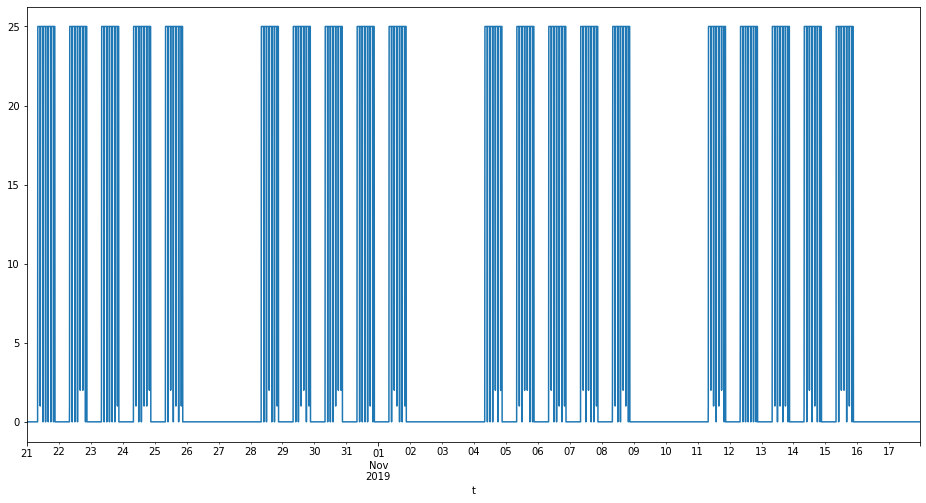

In [4]:
#generated_ts.index = generated_ts.t.rename('index')
#generated_ts.drop(columns=['t'])
generated_ts=pd.read_csv(r'C:\Users\dassu\OneDrive\Desktop\sample_data.csv', index_col = 't', parse_dates=True)
generated_ts = generated_ts[~generated_ts.index.duplicated(keep='first')]
print(generated_ts)
generated_ts = generated_ts.asfreq('5T')
generated_ts['count'].plot(figsize=(16,8))

<AxesSubplot:xlabel='t', ylabel='Resid'>

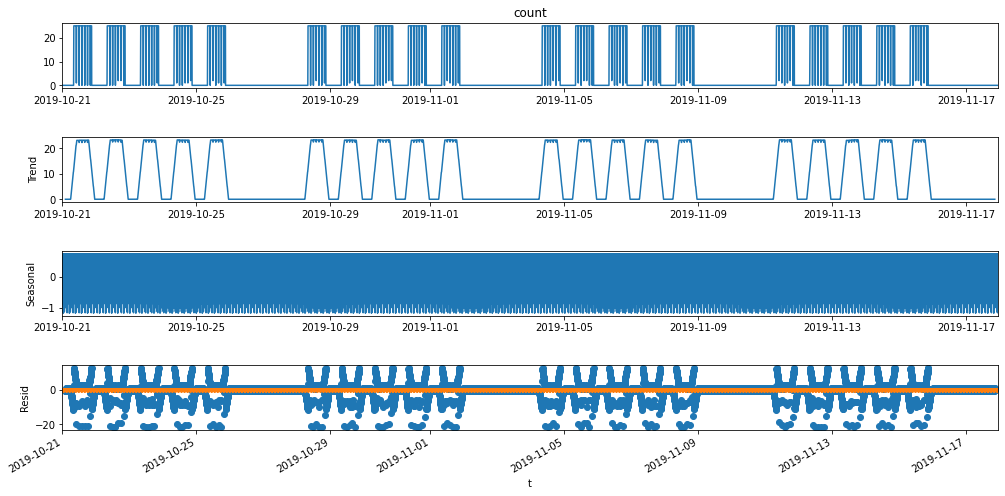

In [18]:
# Forecasting models derivation - on the example of SARIMAX
# References:
# http://www.statsmodels.org/dev/tsa.html
# http://www.statsmodels.org/dev/statespace.html
# http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# TODO: figure out the correct frequency for your data; e.g. 'b' for business days, None by default.
#generated_ts.index.freq = 'W'
# TODO: figure out correct coefficients for your data.
#mod = sm.tsa.statespace.SARIMAX(generated_ts['count'].astype(float), order=(1,1,1), season_order=(1,1,1,52))
#res = mod.fit(disp=False)
#print(res.summary())
res = seasonal_decompose(generated_ts['count'], period = 52)
res.plot()
res.seasonal.plot(figsize=(16,8))

In [22]:
from pmdarima import auto_arima
auto_arima(generated_ts['count'], m=7, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=40941.311, Time=18.43 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=42626.956, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=42502.723, Time=1.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=42211.374, Time=2.38 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=42624.956, Time=0.23 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=40948.068, Time=8.55 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=40948.038, Time=7.11 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=40940.918, Time=30.16 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=40948.530, Time=13.90 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=40952.025, Time=30.43 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=40940.688, Time=35.11 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=40948.636, Time=13.77 sec
 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=40942.153, Time=28.24 sec
 ARIMA(2,1,1)(1,0,2)[7] intercept   : AIC=41181.716, Time=33.83 sec
 ARIMA(3,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 8052
Model:             SARIMAX(2, 1, 3)x(1, 0, [1, 2], 7)   Log Likelihood              -20364.460
Date:                                Wed, 22 Jun 2022   AIC                          40746.920
Time:                                        20:01:26   BIC                          40809.862
Sample:                                             0   HQIC                         40768.457
                                               - 8052                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7856      0.026    -30.801      0.000      -0.836      -0.736
ar.L2          0.2072      0.025      8.223      0.000       0.158       0.257
ma.L1          0.9501      0.025     37.547      0.000       0.900       1.000
ma.L2         -0.5298      0.031    -17.317      0.000      -0.590      -0.470
ma.L3         -0.4874      0.008    -59.349      0.000      -0.503      -0.471
ar.S.L7        0.8723      0.025     35.061      0.000       0.824       0.921
ma.S.L7       -0.8585      0.044    -19.460      0.000      -0.945      -0.772
ma.S.L14      -0.0634      0.034     -1.889      0.059      -0.129       0.002
sigma2         9.1031      0.081    112.883      0.000       8.945       9.261
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            132125.94
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\dassu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='t'>

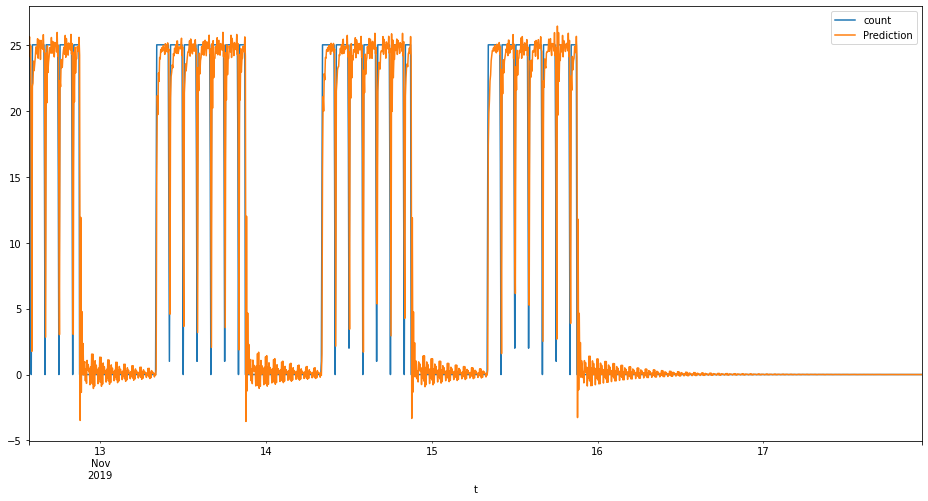

In [23]:
#SARIMAX(2, 1, 3)x(1, 0, [1, 2], 7)
train_df = generated_ts.iloc[:6500]
test_df = generated_ts.iloc[6500:]
mod = sm.tsa.statespace.SARIMAX(generated_ts['count'], order=(2,1,3), seasonal_order=(1, 0, [1,2], 7))
res = mod.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end).rename('Prediction')
ax = test_df['count'].plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

C:\Users\dassu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


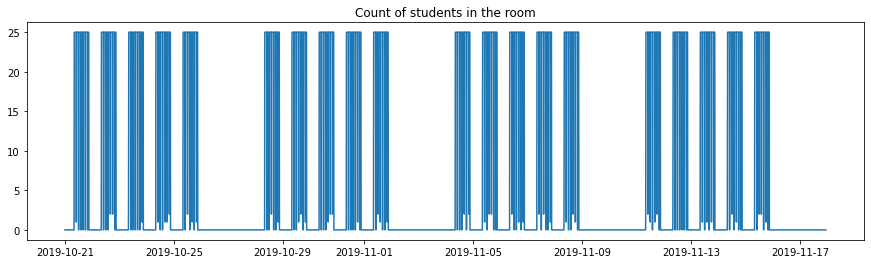

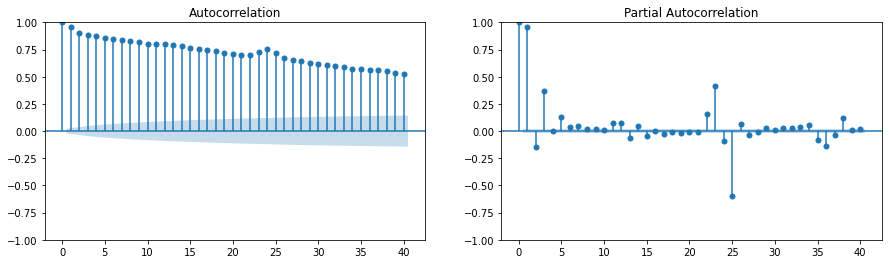

In [19]:
# Visualization and analysis
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(15,4))

# Visualizing the original data
axes.plot(generated_ts.index._mpl_repr(), generated_ts['count'], '-')
axes.set(title = 'Count of students in the room')

# Visualizing ACF and PACF of time series
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(generated_ts.iloc[1:]['count'].astype('float'), lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(generated_ts.iloc[1:]['count'].astype('float'), lags=40, ax=axes[1])

In [20]:
# Predictions

# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

# Dynamic predictions
dyn_pred_start = generated_ts.index[0]
predict_dy = res.get_prediction(start = dyn_pred_start)
predict_dy_ci = predict_dy.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title = 'Count of students in the room', xlabel='Date', ylabel='Students')
ax.set_ylim([0, 30])

# Plot data points
generated_ts.loc[dyn_pred_start:, 'count'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc[dyn_pred_start:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc[dyn_pred_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc[dyn_pred_start:].plot(ax=ax, style='g', label='Dynamic forecast (?)')
ci = predict_dy_ci.loc[dyn_pred_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

AttributeError: 'DecomposeResult' object has no attribute 'get_prediction'